In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=e0d14265f5d5d2e2040064961cbad00b2082c1072d4e3be12289d05416d8f1a9
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import logging


In [5]:
spark =  SparkSession.builder\
    .appName('MyData') \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

df = spark.read \
         .option("header", "true") \
         .csv("/content/gdrive/MyDrive/UserBehavior.csv") \
         .toDF("user_id", "item_id", "category_id", "action_type","timestamp")


In [ ]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- action_type: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [ ]:
df.show()

+-------+-------+-----------+-----------+----------+
|user_id|item_id|category_id|action_type| timestamp|
+-------+-------+-----------+-----------+----------+
|      1|2333346|    2520771|         pv|1511561733|
|      1|2576651|     149192|         pv|1511572885|
|      1|3830808|    4181361|         pv|1511593493|
|      1|4365585|    2520377|         pv|1511596146|
|      1|4606018|    2735466|         pv|1511616481|
|      1| 230380|     411153|         pv|1511644942|
|      1|3827899|    2920476|         pv|1511713473|
|      1|3745169|    2891509|         pv|1511725471|
|      1|1531036|    2920476|         pv|1511733732|
|      1|2266567|    4145813|         pv|1511741471|
|      1|2951368|    1080785|         pv|1511750828|
|      1|3108797|    2355072|         pv|1511758881|
|      1|1338525|     149192|         pv|1511773214|
|      1|2286574|    2465336|         pv|1511797167|
|      1|5002615|    2520377|         pv|1511839385|
|      1|2734026|    4145813|         pv|15118

In [ ]:
for c in df.columns:
    null_count = df.filter(col(c).isNull()).count()
    print("col: {}, number of Null: {}".format(c, null_count))


col: user_id, number of Null: 0
col: item_id, number of Null: 0
col: category_id, number of Null: 0
col: action_type, number of Null: 0
col: timestamp, number of Null: 0


There are no missing value

In [ ]:
df_duplicates = df.dropDuplicates()

if df.count() == df_duplicates.count():
    print("No duplicates found")
else:
    print("Duplicates found and removed")


Duplicates found and removed


Since dataset collect from Chinese plateform, so the timezone is GMT+8

In [6]:
df = df.withColumn("datetime", from_utc_timestamp(from_unixtime(col("timestamp")), "GMT+8"))
df = df.withColumn("date", split(col("datetime"), " ").getItem(0))  
df = df.withColumn("time", split(col("datetime"), " ").getItem(1)) 

df = df.drop("timestamp")
df.show()

+-------+-------+-----------+-----------+-------------------+----------+--------+
|user_id|item_id|category_id|action_type|           datetime|      date|    time|
+-------+-------+-----------+-----------+-------------------+----------+--------+
|      1|2333346|    2520771|         pv|2017-11-25 06:15:33|2017-11-25|06:15:33|
|      1|2576651|     149192|         pv|2017-11-25 09:21:25|2017-11-25|09:21:25|
|      1|3830808|    4181361|         pv|2017-11-25 15:04:53|2017-11-25|15:04:53|
|      1|4365585|    2520377|         pv|2017-11-25 15:49:06|2017-11-25|15:49:06|
|      1|4606018|    2735466|         pv|2017-11-25 21:28:01|2017-11-25|21:28:01|
|      1| 230380|     411153|         pv|2017-11-26 05:22:22|2017-11-26|05:22:22|
|      1|3827899|    2920476|         pv|2017-11-27 00:24:33|2017-11-27|00:24:33|
|      1|3745169|    2891509|         pv|2017-11-27 03:44:31|2017-11-27|03:44:31|
|      1|1531036|    2920476|         pv|2017-11-27 06:02:12|2017-11-27|06:02:12|
|      1|2266567

Since the dataset include 2017/11/25 - 2017/12/3, I will drop other data which are not in the period. 

Action Type :  
- PV - Page View  
- buy  
- cart   
- fav 


In [7]:
from pyspark.sql.functions import col

In [8]:
df = df.filter((col("date") >= lit("2017-11-25")) & (col("date") <= lit("2017-12-03")))

In [9]:
df = df.withColumn('hour', hour('time'))

Based on daily access traffic analysis.

In [ ]:
df.groupBy('date', 'user_id').count().show()

+----------+-------+-----+
|      date|user_id|count|
+----------+-------+-----+
|2017-11-25|    100|   19|
|2017-11-25|   1000|   11|
|2017-11-25| 100000|    5|
|2017-11-25|1000004|    7|
|2017-11-25|1000007|    3|
|2017-11-25|1000014|   52|
|2017-11-25|1000018|    2|
|2017-11-25|1000021|   22|
|2017-11-25|1000025|    1|
|2017-11-25|1000030|   34|
|2017-11-25|1000031|   51|
|2017-11-25|1000034|   17|
|2017-11-25|1000037|    6|
|2017-11-25| 100004|   35|
|2017-11-25|1000040|   36|
|2017-11-25|1000041|   22|
|2017-11-25|1000042|    1|
|2017-11-25|1000043|   17|
|2017-11-25|1000044|    4|
|2017-11-25|1000050|    4|
+----------+-------+-----+
only showing top 20 rows



## Web traffic analysis

### daily Page View



In [ ]:
pv_daily = df.groupBy('date').agg(count('user_id').alias('pv_daily'))
pv_daily.show()

+----------+--------+
|      date|pv_daily|
+----------+--------+
|2017-12-03|13662159|
|2017-12-01|10859436|
|2017-12-02|13777869|
|2017-11-25|10420014|
|2017-11-27|10101147|
|2017-11-28| 9878190|
|2017-11-26|10664602|
|2017-11-30|10447740|
|2017-11-29|10284073|
+----------+--------+



### Unique Vistor

In [ ]:
uv_daily = df.groupBy('date').agg(countDistinct('user_id').alias('uv_daily'))
uv_daily.show()

+----------+--------+
|      date|uv_daily|
+----------+--------+
|2017-12-03|  966977|
|2017-12-01|  740139|
|2017-12-02|  970401|
|2017-11-25|  706641|
|2017-11-27|  710094|
|2017-11-28|  709257|
|2017-11-26|  715516|
|2017-11-30|  730597|
|2017-11-29|  718922|
+----------+--------+



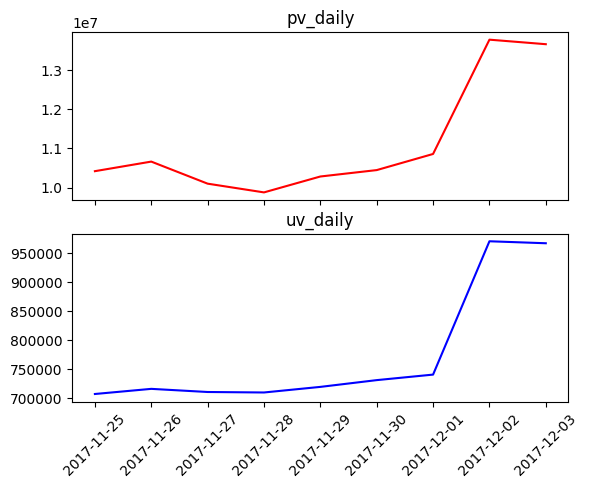

In [ ]:
pv_daily = pv_daily.orderBy(asc('date'))
uv_daily = uv_daily.orderBy(asc('date'))

pv_daily_pd = pv_daily.toPandas()
uv_daily_pd = uv_daily.toPandas()

fig, axes = plt.subplots(2,1,sharex=True)
axes[0].plot(pv_daily_pd['date'], pv_daily_pd['pv_daily'], color='red')
axes[1].plot(uv_daily_pd['date'], uv_daily_pd['uv_daily'], color='blue')
plt.xticks(rotation=45)
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')
plt.show()


Based on the above chart, both page views and unique views reached their peak on the sceond of Dec and then declined. After checking, 12/02 and 12/03 are weekend, there are more people in weekend than weekday.

In [ ]:
df.orderBy(desc('date'),desc('time')).show(10)

+-------+-------+-----------+-----------+-------------------+----------+--------+----+
|user_id|item_id|category_id|action_type|           datetime|      date|    time|hour|
+-------+-------+-----------+-----------+-------------------+----------+--------+----+
| 144017| 554088|     866301|        buy|2017-12-03 23:59:59|2017-12-03|23:59:59|  23|
| 867421|4113292|    3702593|       cart|2017-12-03 23:59:59|2017-12-03|23:59:59|  23|
| 619469|2917531|      58498|        fav|2017-12-03 23:59:59|2017-12-03|23:59:59|  23|
| 871420|3941546|    3497230|        buy|2017-12-03 23:59:59|2017-12-03|23:59:59|  23|
| 472821| 481452|    2520377|        fav|2017-12-03 23:59:59|2017-12-03|23:59:59|  23|
|  89523|3905977|    2732466|        fav|2017-12-03 23:59:59|2017-12-03|23:59:59|  23|
| 749100| 805058|    2520377|       cart|2017-12-03 23:59:59|2017-12-03|23:59:59|  23|
| 933887|3657454|    3738615|       cart|2017-12-03 23:59:59|2017-12-03|23:59:59|  23|
| 333794|1959402|    3100520|        buy|20

In [ ]:
df.filter((df.date == '2017-12-02')).orderBy(desc('time')).show(10)

+-------+-------+-----------+-----------+-------------------+----------+--------+----+
|user_id|item_id|category_id|action_type|           datetime|      date|    time|hour|
+-------+-------+-----------+-----------+-------------------+----------+--------+----+
|1000856|3865796|    2520771|         pv|2017-12-02 23:59:59|2017-12-02|23:59:59|  23|
| 811079|2020265|    1834026|         pv|2017-12-02 23:59:59|2017-12-02|23:59:59|  23|
| 959844|3564596|    1651662|       cart|2017-12-02 23:59:59|2017-12-02|23:59:59|  23|
| 851229|3028187|    3738615|         pv|2017-12-02 23:59:59|2017-12-02|23:59:59|  23|
| 631980|1201669|    1286537|         pv|2017-12-02 23:59:59|2017-12-02|23:59:59|  23|
| 796833|1616494|    4358294|         pv|2017-12-02 23:59:59|2017-12-02|23:59:59|  23|
| 991540|3162930|    1879194|         pv|2017-12-02 23:59:59|2017-12-02|23:59:59|  23|
| 827958| 981297|     983613|         pv|2017-12-02 23:59:59|2017-12-02|23:59:59|  23|
| 458497|3910351|     200278|         pv|20

## hour traffic analysis

In [12]:
# Calculating PV per hour.
pv_hour = df.groupBy('hour').agg(count('user_id').alias('pv_hour'))
pv_hour.show(10)

In [13]:
# Calculating UV per hour.
uv_hour = df.groupBy('hour').agg(countDistinct('user_id').alias('uv_hour'))
uv_hour.show()

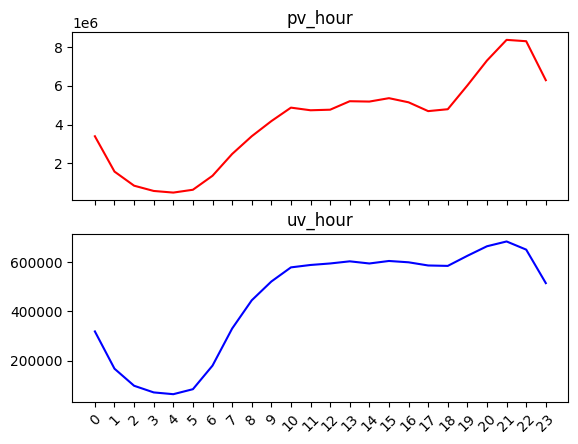

In [ ]:
pv_hour = pv_hour.orderBy(asc('hour'))
uv_hour = uv_hour.orderBy(asc('hour'))

pv_hour_pd = pv_hour.toPandas()
uv_hour_pd = uv_hour.toPandas()

fig, axes = plt.subplots(2,1,sharex=True)
axes[0].plot(pv_hour_pd['hour'], pv_hour_pd['pv_hour'], color='red')
axes[1].plot(uv_hour_pd['hour'], uv_hour_pd['uv_hour'], color='blue')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 24, 1))
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')
plt.show()


The overall trend of these two graphs is consistent, with the lowest point reached around 4 a.m. followed by a gradual increase. There is little variation in the viewing volume around 10 a.m. The viewing volume starts to rise from 5 p.m. and peaks at 9 p.m. One possible explanation for the relatively unchanged viewing volume in the afternoon could be that a majority of people have started working during that time period, resulting in minimal changes.

Based on the similarity of the patterns between December 2nd and December 3rd, both being weekends, I will conduct a detailed analysis on the data specifically for December 2nd.

In [10]:
df_1202 = df.filter(df['date'] == '2017-12-02')
pv_hour_1202 = df_1202.groupBy('hour').agg({'user_id': 'count'}).withColumnRenamed('count(user_id)', '1202_pv_hour')
uv_hour_1202 = df_1202.groupBy('hour').agg(countDistinct('user_id').alias('1202_uv_hour')).withColumnRenamed('count(DISTINCT user_id)', '1202_uv_hour')


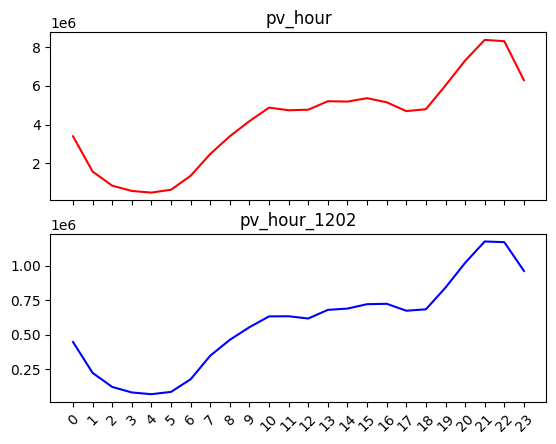

In [14]:
pv_hour = pv_hour.orderBy(asc('hour'))
pv_hour_1202 = pv_hour_1202.orderBy(asc('hour'))

pv_hour_pd = pv_hour.toPandas()
pv_hour_1202_pd = pv_hour_1202.toPandas()

fig, axes = plt.subplots(2,1,sharex=True)
axes[0].plot(pv_hour_pd['hour'], pv_hour_pd['pv_hour'], color='red')
axes[1].plot(pv_hour_1202_pd['hour'], pv_hour_1202_pd['1202_pv_hour'], color='blue')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 24, 1))
axes[0].set_title('pv_hour')
axes[1].set_title('pv_hour_1202')
plt.show()


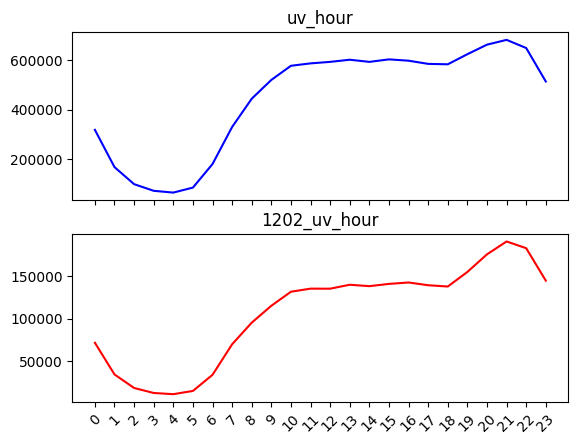

In [15]:
uv_hour_1202 = uv_hour_1202.orderBy(asc('hour'))
uv_hour = uv_hour.orderBy(asc('hour'))

uv_hour_1202_pd = uv_hour_1202.toPandas()
uv_hour_pd = uv_hour.toPandas()

fig, axes = plt.subplots(2,1,sharex=True)
axes[0].plot(uv_hour_pd['hour'], uv_hour_pd['uv_hour'], color='blue')
axes[1].plot(uv_hour_1202_pd['hour'], uv_hour_1202_pd['1202_uv_hour'], color='red')

plt.xticks(rotation=45)
plt.xticks(np.arange(0, 24, 1))
axes[0].set_title('uv_hour')
axes[1].set_title('1202_uv_hour')
plt.show()


From the above figure, it can be concluded that the UV and PV on December 2nd are same as the previous results.

## Analysis of traffic based on different user behaviors

Taobao has a wide range of user distribution, and different users have significant differences in their shopping behaviors. For example, users may have different login habits and purchase preferences. Therefore, analyzing from the perspective of users is important and interesting. In order to obtain user behavior patterns, we mainly analyze the behaviors that users engage in throughout the day (per hour). 

In [16]:
pv_behavior = df.groupBy(['action_type', 'hour'])\
    .agg(count('user_id').alias('pv_behavior'))\
    .select('action_type', 'hour', 'pv_behavior')
pv_behavior = pv_behavior.orderBy(asc('action_type'),asc('hour'))
pv_behavior.show()

+-----------+----+-----------+
|action_type|hour|pv_behavior|
+-----------+----+-----------+
|        buy|   0|      57776|
|        buy|   1|      23169|
|        buy|   2|      12012|
|        buy|   3|       8026|
|        buy|   4|       6748|
|        buy|   5|       8135|
|        buy|   6|      18014|
|        buy|   7|      37679|
|        buy|   8|      64917|
|        buy|   9|      96134|
|        buy|  10|     127933|
|        buy|  11|     122048|
|        buy|  12|     118591|
|        buy|  13|     123427|
|        buy|  14|     122172|
|        buy|  15|     122733|
|        buy|  16|     116446|
|        buy|  17|     101301|
|        buy|  18|      95907|
|        buy|  19|     115032|
+-----------+----+-----------+
only showing top 20 rows



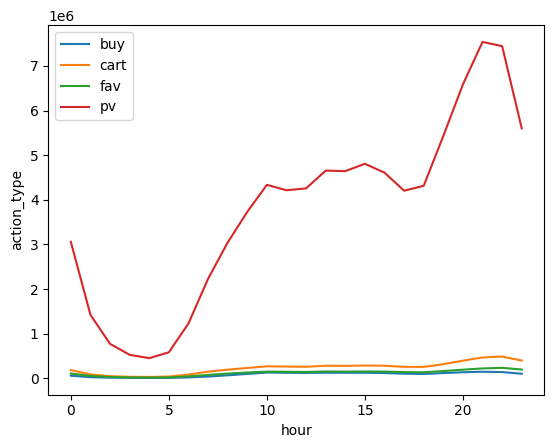

In [17]:
pv_behavior_pd = pv_behavior.toPandas()

fig, ax = plt.subplots()
for action_type, grp in pv_behavior_pd.groupby('action_type'):
    ax.plot(grp['hour'], grp['pv_behavior'], label=action_type)
ax.legend()
ax.set_xlabel('hour')
ax.set_ylabel('action_type')
plt.show()

Because the proportion of 'pv' is very large, it makes the trends of the other types of actions less obvious in the chart.

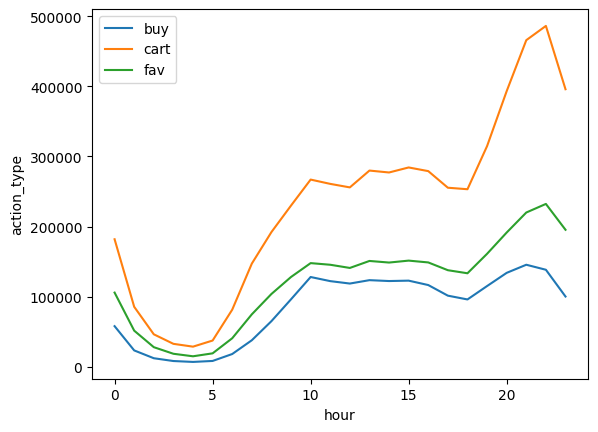

In [18]:
pv_behavior_without_pv = pv_behavior.filter(~(col('action_type') == 'pv'))
pv_behavior_without_pv_pd = pv_behavior_without_pv.toPandas()


fig, ax = plt.subplots()
for action_type, grp in pv_behavior_without_pv_pd.groupby('action_type'):
    ax.plot(grp['hour'], grp['pv_behavior'], label=action_type)
ax.legend()
ax.set_xlabel('hour')
ax.set_ylabel('action_type')
plt.show()

According to the figure, the hourly trend of the four types of behaviors is basically the same, reaching a peak around 7-8am and then dropping to a low point around noon. One possible reason is that 7-8am is the commuting time to work, and people may browse and shop while on the way. After entering work, the frequency decreases and reaches a low point around 12-1pm. As the work time increases and work intensity decreases, the time spent browsing on mobile phones increases, leading to an increase in frequency. Therefore, merchants can push promotional activities during peak hours to improve conversion rates.

## Funnel Analysis

In [19]:
action_type = df.groupBy(col('action_type')).agg(count('user_id').alias('count'))

In [20]:
action_type.orderBy(desc('count')).show()

+-----------+--------+
|action_type|   count|
+-----------+--------+
|         pv|89660687|
|       cart| 5530446|
|        fav| 2888258|
|        buy| 2015839|
+-----------+--------+



Since adding items to the shopping cart and adding items to the wish list belong to the same type of behavior, I will merge them together.

In [21]:
pv_to_cart_fav_rate =  ((action_type.filter(col('action_type') == 'cart').select('count').collect()[0][0] +
action_type.filter(col('action_type') == 'fav').select('count').collect()[0][0]) /action_type.filter(col('action_type') == 'pv').select('count').collect()[0][0]) * 100

print("Page view to cart and favorite rate : " + str(pv_to_cart_fav_rate) + "%")

Page view to cart and favorite rate : 9.38951538481966%


In [22]:
pv_to_buy_rate = (action_type.filter(col('action_type') == 'buy').select('count').collect()[0][0] / action_type.filter(col('action_type') == 'pv').select('count').collect()[0][0]) * 100

print("Page view to buy rate : " + str(pv_to_buy_rate) + "%")

Page view to buy rate : 2.248297517506195%


In [23]:
cart_fav_to_buy_rate = (action_type.filter(col('action_type') == 'buy').select('count').collect()[0][0] / (action_type.filter(col('action_type') == 'cart').select('count').collect()[0][0] + (action_type.filter(col('action_type') == 'cart').select('count').collect()[0][0]))) * 100

print("Cart and favorite to buy rate : " + str(cart_fav_to_buy_rate) + "%")

Cart and favorite to buy rate : 18.22492254693383%


Based on the analysis, the conversion rate from browsing to adding to cart/favorite is approximately 9.39%, while the conversion rate from adding to cart/favorite to purchase is about 18.15%. The overall conversion rate from browsing to purchase is approximately 2.24%.

In [24]:
action_type_1202 = df_1202.groupBy(col('action_type')).agg(count('user_id').alias('count'))
action_type.orderBy(desc('count')).show()

+-----------+--------+
|action_type|   count|
+-----------+--------+
|         pv|89660687|
|       cart| 5530446|
|        fav| 2888258|
|        buy| 2015839|
+-----------+--------+



In [25]:
pv_to_cart_fav_rate_1202 =  ((action_type_1202.filter(col('action_type') == 'cart').select('count').collect()[0][0] +
action_type_1202.filter(col('action_type') == 'fav').select('count').collect()[0][0]) /action_type_1202.filter(col('action_type') == 'pv').select('count').collect()[0][0]) * 100

print("12/02 Page view to cart and favorite rate : " + str(pv_to_cart_fav_rate_1202) + "%")

12/02 Page view to cart and favorite rate : 9.654114911995837%


In [26]:
pv_to_buy_rate_1202 = (action_type_1202.filter(col('action_type') == 'buy').select('count').collect()[0][0] / action_type_1202.filter(col('action_type') == 'pv').select('count').collect()[0][0]) * 100

print("12/02 Page view to buy rate : " + str(pv_to_buy_rate_1202) + "%")

12/02 Page view to buy rate : 2.0917635578123748%


In [58]:
cart_fav_to_buy_rate_1202 = (action_type_1202.filter(col('action_type') == 'buy').select('count').collect()[0][0] / (action_type_1202.filter(col('action_type') == 'cart').select('count').collect()[0][0] + (action_type.filter(col('action_type') == 'cart').select('count').collect()[0][0]))) * 100

print("12/02 Cart and favorite to buy rate : " + str(cart_fav_to_buy_rate_1202) + "%")

12/02 Cart and favorite to buy rate : 4.0782161332634415%


By separately analyzing the date with the highest PV/UV on 12/02, it was found that there was no significant change in user behavior, and the conversion rate from adding to cart to purchase even decreased by two percentage points. Therefore, it can be concluded that the reason for the high PV/UV on 12/02 may be due to the weekend.

## FRM


Because this dataset does not include the amount of consumption, only the recent purchase time and the number of purchases are used to measure customer value here.

In [28]:
buy = df.filter(col('action_type') == 'buy')
buy.show()

+-------+-------+-----------+-----------+-------------------+----------+--------+----+
|user_id|item_id|category_id|action_type|           datetime|      date|    time|hour|
+-------+-------+-----------+-----------+-------------------+----------+--------+----+
|    100|1603476|    2951233|        buy|2017-11-25 11:18:28|2017-11-25|11:18:28|  11|
|    100|2971043|    4869428|        buy|2017-11-25 21:45:49|2017-11-25|21:45:49|  21|
|    100| 598929|    2429887|        buy|2017-11-27 13:10:58|2017-11-27|13:10:58|  13|
|    100|1046201|    3002561|        buy|2017-11-27 15:21:38|2017-11-27|15:21:38|  15|
|    100|1606258|    4098232|        buy|2017-11-27 21:39:00|2017-11-27|21:39:00|  21|
|    100|4840649|    1029459|        buy|2017-11-27 21:42:10|2017-11-27|21:42:10|  21|
|    100| 251391|    3738615|        buy|2017-11-27 21:53:02|2017-11-27|21:53:02|  21|
|    100|4075065|    2881542|        buy|2017-11-28 09:51:17|2017-11-28|09:51:17|   9|
|1000001|4088463|     174239|        buy|20

Since the dataset include 11.25 to 12.04, so I set 12.04 as a reference date.


In [ ]:
# calculate recent buy date
recency = buy.select("user_id", datediff(lit('2017-12-04'), buy.date).alias("Recency"))

# calculate frequency
frequency = buy.groupBy('user_id').agg(count('user_id').alias('Frequency'))

In [30]:
FR_Model = df
FR_Model = df.join(recency, 'user_id').join(frequency, 'user_id')

In [31]:
recency_quartiles = recency.approxQuantile("Recency", [0.25, 0.5, 0.75], 0.01)
recency_quartiles


[2.0, 5.0, 7.0]

In [ ]:
freq_quartiles = frequency.approxQuantile("Frequency", [0.25, 0.5, 0.75], 0.01)
freq_quartiles

I calculate the quantile of recency and frequency, so I set 7 and 4 as threshold. Beyond it, I consider he/she as a loyal customer.

In [ ]:
FR_Model = recency.join(frequency, 'user_id')
FR_Model = FR_Model.withColumn("R", when(FR_Model["Recency"] <= 3, "High").otherwise("Low"))
FR_Model = FR_Model.withColumn("F", when(FR_Model["Frequency"] >= 4, "High").otherwise("Low"))


In [ ]:
min_R = FR_Model.groupBy('user_id').agg(min('R').alias('min_R'))
min_R_Model = FR_Model.join(min_R, 'user_id').filter(col('R') == col('min_R')).drop('min_R')

In [ ]:
FR_Model = min_R_Model.groupBy('user_id').agg(min('R').alias('R'), min('F').alias('F'))
FR_Model = FR_Model.withColumn("RMF", 
                             when((FR_Model["R"] == "High") & (FR_Model["F"] == "High"), "High-Value Customers")
                             .when((FR_Model["R"] == "High") & (FR_Model["F"] == "Low"), "New Customers")
                             .when((FR_Model["R"] == "Low") & (FR_Model["F"] == "High"), "At-Risk Customers")
                             .when((FR_Model["R"] == "Low") & (FR_Model["F"] == "Low"), "Low-Value Customers"))


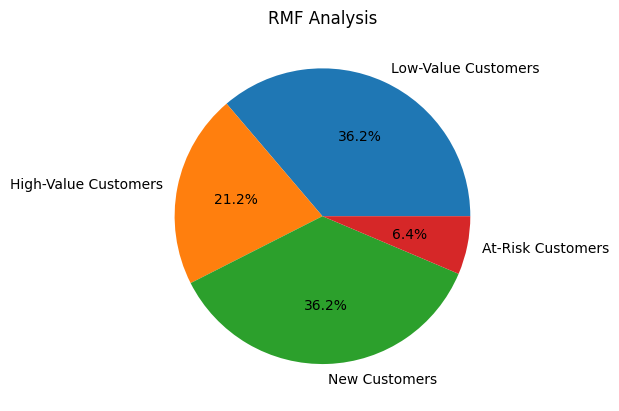

In [36]:
fr_count = FR_Model.groupBy("RMF").agg(count("*").alias("count"))

fr_count_pd = fr_count.toPandas()


plt.pie(fr_count_pd["count"], labels=fr_count_pd["RMF"], autopct="%1.1f%%")
plt.title("RMF Analysis")
plt.show()

## ARPU

ARPU (Average Revenue Per User) represents the conversion of daily revenue among all active users. Specifically, it is calculated by dividing daily revenue by the number of daily active users, thus indicating the efficiency of converting daily active users into revenue.

The dataset does not contain any monetary values. Therefore, we can modify the ARPU metric to measure the average daily consumption per active user on the platform.

The calculation formula is: ARPU = Total daily consumption / Daily active users


In [ ]:
# add 1 for each user login in each day
data_userdf = df.withColumn('loging', lit(1))

df_arpu = data_userdf.groupBy('user_id', 'date', 'action_type').agg(count('loging').alias('count'))


In [ ]:
# ARPU = Total daily consumption / Daily active users
arpu = df_arpu.filter(col('action_type') == 'buy').groupBy('date').agg(sum('count').alias('daily_consumption'), approx_count_distinct('user_id').alias('daily_active_users'))
arpu = arpu.withColumn('ARPU', col('daily_consumption') / col('daily_active_users')).select('date', 'ARPU')



In [ ]:
arpu = df_arpu.filter(col('action_type') == 'buy').groupBy('date') \
            .agg(sum('count').alias('daily_consumption'), \
                 approx_count_distinct('user_id').alias('daily_active_users')) \
            .withColumn('ARPU', col('daily_consumption') / col('daily_active_users')) \
            .select('date', 'ARPU')

arpu_pd = arpu.toPandas()
arpu_pd = arpu_pd.sort_values(by='date')

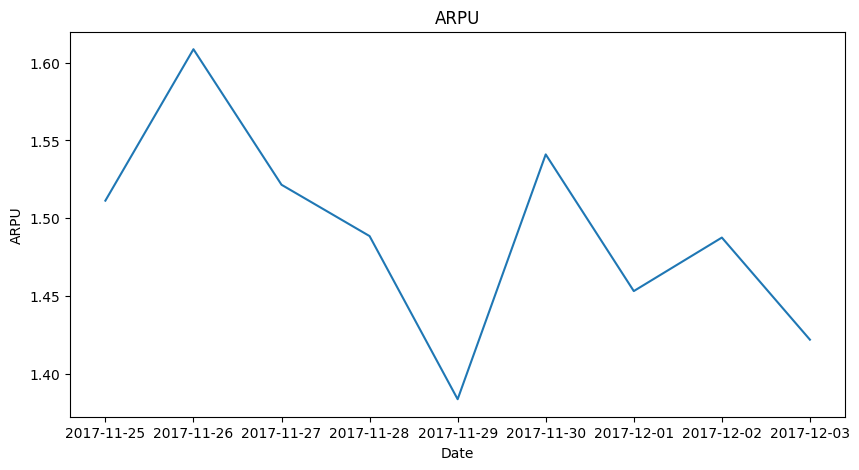

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(arpu_pd['date'], arpu_pd['ARPU'])
plt.title('ARPU')
plt.xlabel('Date')
plt.ylabel('ARPU')
plt.show()

## ARPPU

ARPPU (average revenue per paying user) refers to the revenue obtained from each paying user, reflecting the average consumption of users on the entire platform.

The calculation method is: ARPPU = total revenue / number of paying users. However, there is no revenue amount in this dataset, so we can make a slight modification to the calculation method and convert the total revenue to the total number of purchase behavior.

Defined as follows: ARPPU = total number of purchases / number of active paying users on that day. It can be seen that the only difference between ARPU and ARPPU is the denominator. The denominator of ARPU is the number of active users (including 4 types of behavior), while the denominator of ARPPU is the number of active paying users, so the calculation of ARPPU will be simpler.

In [49]:
df_arppu = df.filter(df.action_type == 'buy') \
    .groupBy(['date', 'user_id']) \
    .agg(count('*').alias('buy_count')) \
    .select(['date', 'user_id', 'buy_count'])


In [50]:
buy_data = df.filter(df.action_type == 'buy')
daily_buy_count = buy_data.groupby(['date', 'user_id']).agg(count('action_type').alias('buy_count'))
total_daily_buy_count = daily_buy_count.groupby('date').agg(sum('buy_count').alias('daily_buy_count'), count('user_id').alias('daily_active_paying_users'))
arppu = total_daily_buy_count.withColumn('ARPPU', col('daily_buy_count') / col('daily_active_paying_users')).select('date', 'ARPPU')

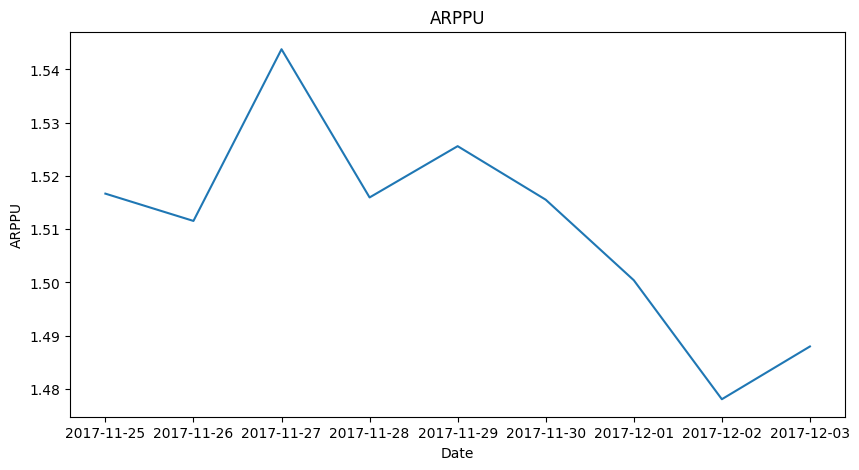

In [51]:
buy_actions = df.filter(df.action_type == 'buy')

buy_count = buy_actions.groupBy('date', 'user_id').agg(count('user_id').alias('buy_count'))

arppu = buy_count.groupBy('date').agg(sum('buy_count').alias('total_buy_count'), count('user_id').alias('active_paying_users'))

arppu = arppu.withColumn('ARPPU', col('total_buy_count') / col('active_paying_users')).select('date', 'ARPPU')

arppu_pd = arppu.toPandas()
arppu_pd = arppu_pd.sort_values(by='date')

plt.figure(figsize=(10, 5))
plt.plot(arpu_pd['date'], arppu_pd['ARPPU'])
plt.title('ARPPU')
plt.xlabel('Date')
plt.ylabel('ARPPU')
plt.show()



## item


### Page View

In [52]:
pv_df = df.filter(df["action_type"] == "pv")

# Calculate the number of page views for each item
item_pv_counts = pv_df.groupBy("item_id").agg(count("*").alias("pv_count_item")).orderBy(desc("pv_count_item"))

# Calculate the number of page views for each category
category_pv_counts = pv_df.groupBy("category_id").agg(count("*").alias("pv_count_category")).orderBy(desc("pv_count_category"))

# Calculate the top item for each category
pv_category_top_item = pv_df.groupBy("category_id").agg(max("item_id").alias("top_item")).orderBy(desc("top_item"))


item_pv_counts.show()
category_pv_counts.show()
pv_category_top_item.show()


+-------+-------------+
|item_id|pv_count_item|
+-------+-------------+
| 812879|        30079|
|3845720|        25650|
| 138964|        21103|
|2331370|        19482|
|2032668|        19141|
|1535294|        17840|
|  59883|        17404|
|4211339|        17349|
|3031354|        17169|
|3371523|        17159|
|2338453|        17069|
|2367945|        16190|
|1591862|        16185|
| 987143|        15988|
|2818406|        15980|
|4649427|        15144|
|1583704|        14779|
|2453685|        14569|
|2279428|        14257|
|4443059|        14082|
+-------+-------------+
only showing top 20 rows

+-----------+-----------------+
|category_id|pv_count_category|
+-----------+-----------------+
|    4756105|          4477682|
|    2355072|          3151734|
|    4145813|          3150716|
|    3607361|          2976359|
|     982926|          2798730|
|    2520377|          2029468|
|    4801426|          1864651|
|    1320293|          1793240|
|    2465336|          1504738|
|    3002561| 

In [53]:
fav_df = df.filter(df["action_type"] == "fav")

# calculate the number of fav for each item
item_fav_count = fav_df.groupBy("item_id").agg(count("*").alias("fav_count_item")).orderBy(desc("fav_count_item"))

# calculate the number of fav for each category
category_fav_count = fav_df.groupBy("category_id").agg(count("*").alias("fav_count_category")).orderBy(desc("fav_count_category"))


# calculate the top item for each category
fav_category_top_items = fav_df.groupBy("category_id").agg(max("item_id").alias("top_item")).orderBy(desc("top_item"))



item_fav_count.show()
category_fav_count.show()
fav_category_top_items.show()

+-------+--------------+
|item_id|fav_count_item|
+-------+--------------+
|2279428|           971|
| 812879|           875|
|2331370|           873|
|2818406|           822|
|3330337|           710|
|3845720|           702|
|1535294|           675|
| 138964|           642|
|2453685|           636|
|2364679|           621|
|1583704|           578|
|1783990|           556|
|1419997|           534|
|2032668|           517|
|3031354|           513|
|1343119|           483|
|4649427|           476|
| 740947|           474|
|3403645|           469|
|2783905|           453|
+-------+--------------+
only showing top 20 rows

+-----------+------------------+
|category_id|fav_count_category|
+-----------+------------------+
|    4756105|            139373|
|    4145813|            110666|
|     982926|             89137|
|    2355072|             87241|
|    3607361|             71334|
|    4801426|             68319|
|    2520377|             67400|
|    2465336|             54946|
|    300256

In [54]:
cart_df = df.filter(df["action_type"] == "cart")

# calculate the number of cart for each item
item_cart_count = cart_df.groupBy("item_id").agg(count("*").alias("cart_count_item")).orderBy(desc("cart_count_item"))


# calculate the number of cart for each category
category_cart_count = cart_df.groupBy("category_id").agg(count("*").alias("cart_count_category")).orderBy(desc("cart_count_category"))


# calculate the top item for each category
cart_category_top_items = cart_df.groupBy("category_id").agg(max("item_id").alias("top_item")).orderBy(desc("top_item"))


item_cart_count.show()
category_cart_count.show()
cart_category_top_items.show()

+-------+---------------+
|item_id|cart_count_item|
+-------+---------------+
|3031354|           1761|
| 812879|           1528|
|2331370|           1513|
|2818406|           1415|
|2560262|           1271|
| 138964|           1133|
|1535294|           1114|
|1583704|           1106|
|2453685|           1053|
|2279428|            981|
|4443059|            951|
| 363858|            908|
| 705557|            877|
|4211339|            863|
|4736400|            860|
|3715112|            856|
|3845720|            851|
|1684440|            849|
|2521928|            835|
|1444258|            821|
+-------+---------------+
only showing top 20 rows

+-----------+-------------------+
|category_id|cart_count_category|
+-----------+-------------------+
|    4756105|             215146|
|    4145813|             174419|
|     982926|             153906|
|    4801426|             122145|
|    2355072|             121867|
|    3607361|             109102|
|    1320293|              95049|
|    27354

In [56]:
buy_df = df.filter(df["action_type"] == "buy")

# calculate the number of buy for each item
item_buy_count = buy_df.groupBy("item_id").agg(count("*").alias("buy_count_item")).orderBy(desc("buy_count_item"))


# calculate the number of buy for each category
category_buy_count = buy_df.groupBy("category_id").agg(count("*").alias("buy_count_category")).orderBy(desc("buy_count_category"))



# calculate the top item for each category
buy_category_top_items = buy_df.groupBy("category_id").agg(max("item_id").alias("top_item")).orderBy(desc("top_item"))



item_buy_count.show()
category_buy_count.show()
buy_category_top_items.show()

+-------+--------------+
|item_id|buy_count_item|
+-------+--------------+
|3122135|          1408|
|3031354|           950|
|3964583|           675|
|2560262|           665|
|2964774|           629|
| 740947|           560|
|1910706|           548|
|1116492|           512|
| 705557|           497|
|4443059|           493|
|1415828|           488|
|1034594|           481|
|1168232|           465|
|3189426|           453|
|4219087|           442|
| 265985|           441|
| 257772|           404|
|1535294|           402|
|2955846|           394|
|5062984|           391|
+-------+--------------+
only showing top 20 rows

+-----------+------------------+
|category_id|buy_count_category|
+-----------+------------------+
|    1464116|             34591|
|    2735466|             33730|
|    2885642|             31844|
|    4145813|             31658|
|    4756105|             28258|
|    4801426|             26495|
|     982926|             24825|
|    2640118|             18332|
|    415907

In [57]:
item_buy_pv_count = df.filter(df.action_type.isin(['pv', 'buy'])) \
                      .groupBy('item_id') \
                      .agg(sum(when(col('action_type') == 'buy', 1).otherwise(0)).alias('buy_count'),
                           sum(when(col('action_type') == 'pv', 1).otherwise(0)).alias('pv_count'))

item_buy_pv_count = item_buy_pv_count.withColumn('conversion_rate', col('buy_count') / col('pv_count'))

item_buy_pv_count.sort(desc('conversion_rate')).show(10)


+-------+---------+--------+---------------+
|item_id|buy_count|pv_count|conversion_rate|
+-------+---------+--------+---------------+
|  11610|       46|       1|           46.0|
|1117328|       45|       1|           45.0|
|1297895|       44|       1|           44.0|
|1568681|       33|       1|           33.0|
|1102839|       32|       1|           32.0|
|4763455|       32|       1|           32.0|
|1880775|      127|       4|          31.75|
|5045642|       30|       1|           30.0|
|4471603|       52|       2|           26.0|
|4150970|       72|       3|           24.0|
+-------+---------+--------+---------------+
only showing top 10 rows



## Conclusion


Based on the analysis of user behavior, it can be observed that the conversion rate from click to purchase is relatively high, and it is possible to improve the conversion rate from wishlist/cart to purchase. The conversion rate from click to purchase is only 2.24%, so improving this conversion rate is a key focus. Suggestions for this stage include:
Optimizing the search accuracy and recommendation strategy of the e-commerce platform, and optimizing the priority of sorting search and filter results.
Providing customers with product comparison functionality, so that users do not need to repeatedly return to search results for clicking and viewing, making it easier for users to select desired products and increasing the conversion from click to subsequent actions.
Optimizing the process of adding products to wishlist/cart to purchase, increasing the frequency of users adding products to wishlist/cart, in order to improve the purchase conversion rate.
Based on the analysis of user behavior, it can be seen that the peak period of user activity is mainly between 20:00-22:00, during which the user usage is the highest and marketing activities are more likely to reach users. Therefore, marketing activities can be scheduled during this time period for user acquisition and conversion.

During the 9-day study period, there were two weekends. The first weekend did not show a significant change in user activity, while the second weekend showed a significant increase in clicks and cart additions, possibly due to the pre-heating for the Double Twelve (12/12) shopping festival. Therefore, expanding the study time frame for validation can help identify user shopping preferences during weekends and plan marketing activities accordingly.

Highlighting key information that users focus on in the product detail page, optimizing the presentation format, and reducing users' time cost.
Strengthening quality control for these products, and actively managing user feedback and comments to optimize products based on strengths and weaknesses.
Additionally, for the top 20 products in terms of sales, prioritizing their display on the e-commerce homepage to meet users' purchasing needs.
By using the RFM model to segment customer groups, different management strategies can be adopted for different customer segments to achieve precise marketing:
Important high-value customers should be given special attention and maintained, with efforts to improve satisfaction and increase retention.
For New Customers and At-Risk Customers, offering discounts or bundled sales to increase their purchase frequency.
For Low-Value Customers, implementing personalized marketing based on their shopping habits to rekindle their purchase intent.
